In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from glob import glob

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import find_nearest_ind

In [4]:
%matplotlib notebook

In [5]:
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\ref_comp')

### Define electrode locations (only 30 electrodes in EEG array!)
#### Added to EEGexp class

In [6]:
print(len(EEGexp.EEG_channel_order))

30


### Get meta data from files

In [7]:
data_folder = r'P:\mouse676727\aw_psi_2023-05-10_09-49-12\experiment1\recording1'
# data_folder = r"C:\Users\lesliec\data\EEG_exp\mouse521887\estimfull_2020-07-30\experiment1\recordingfull"
exp = EEGexp(data_folder, preprocess=False, make_stim_csv=False)

Experiment type: electrical and sensory stimulation


In [8]:
print(exp.mouse)
print(exp.date)
print(exp.experiment_type)
print(exp.experiment_data)
print(exp.sslog_file)
print(exp.computerID)
print(exp.bodymovie_file)

676727
2023-05-10 09:49:12
electrical and sensory stimulation
['probeB_sorted', 'probeC_sorted', 'probeD_sorted', 'probeF_sorted', 'recording1']

W10DT05491
P:\mouse676727\aw_psi_2023-05-10_09-49-12\experiment1\recording1\230510094857-1.avi


In [9]:
print(exp.ephys_params['EEG']['num_chs'])
print(exp.ephys_params['EEG']['sample_rate'])
print(exp.ephys_params['EEG']['units'])

40
2500
uV


In [10]:
exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

aw_psi


### Use EEGexp function to load data. Array returned is already remapped into EEG array ch numbers (ch 31 & 32 should be very noisy). Data is in microvolts.

In [11]:
eegdata, eegtimestamps = exp.load_eegdata()

In [12]:
print(eegdata.shape)

(13202688, 30)


In [13]:
print(eegtimestamps[0:10])
print(eegtimestamps.shape)

[25.33023491 25.33063491 25.33103491 25.33143491 25.33183492 25.33223492
 25.33263492 25.33303492 25.33343492 25.33383492]
(13202688,)


#### Plot raw signals in a window

Common average ref

<IPython.core.display.Javascript object>


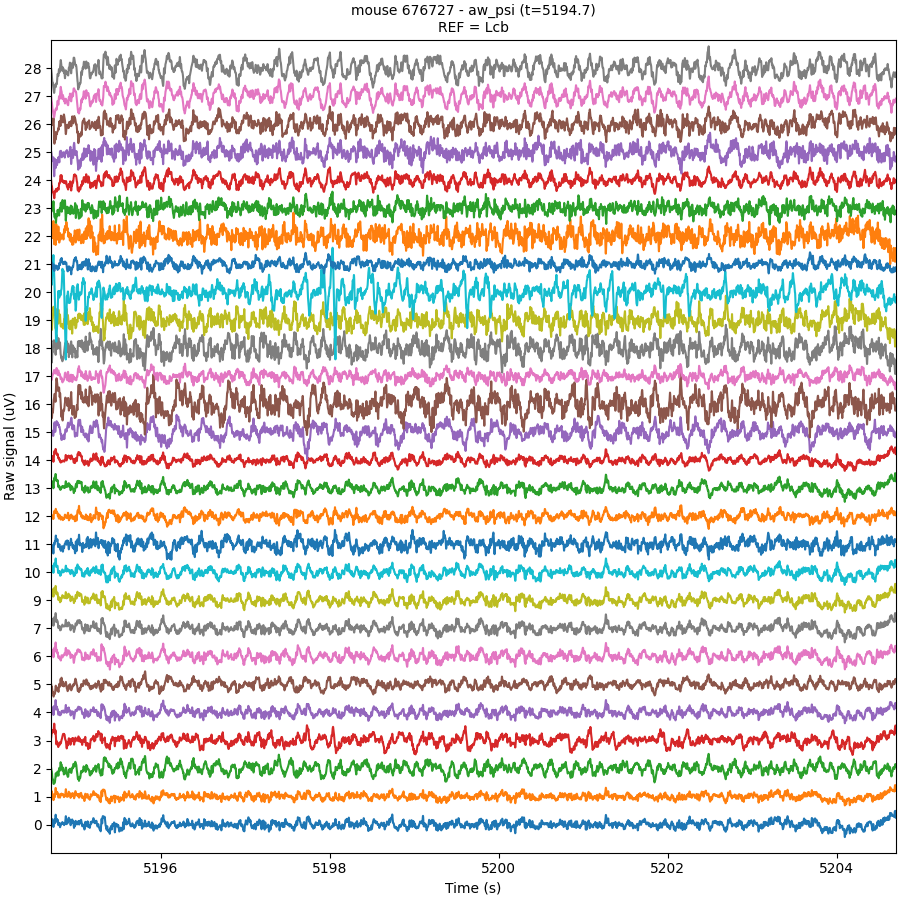

In [17]:
tstart = 5194.7
ref_tag = 'Lcb'

twin = 10.0 # s
startind = find_nearest_ind(eegtimestamps, tstart)
endind = startind + int(twin * exp.ephys_params['EEG']['sample_rate'])

## Signal processing ##
bad_chs = [8,29]
GOOD_CHS = np.array([x for x in range(eegdata.shape[1]) if x not in bad_chs])
rawdata = eegdata[startind:endind,GOOD_CHS]
comref_data = rawdata - np.mean(rawdata, axis=1)[:,None]

## Design Butterworth bandpass filter ##
filtb, filta = signal.butter(3, np.array([0.5, 100])/(exp.ephys_params['EEG']['sample_rate']/2), btype='bandpass')
filtdata = signal.filtfilt(filtb, filta, comref_data, axis=0)

offset = 150
fig, ax = plt.subplots(figsize=(9,9), constrained_layout=True)

for i, chi in enumerate(GOOD_CHS):
    ax.plot(eegtimestamps[startind:endind], filtdata[:,i] + i*offset)

ax.set_xlim((eegtimestamps[startind], eegtimestamps[endind]))
ax.set_ylim((-offset, 1.75+offset*(i+1)))
ax.set_yticks(np.arange(0, offset*(i+1), offset))
ax.set_yticklabels(GOOD_CHS)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Raw signal (uV)')
ax.set_title('mouse {} - {} (t={:.1f})\nREF = {}'.format(exp.mouse, exp_tag, tstart, ref_tag))
# ax.legend()

### SAVE ###
figname = '{}_{}_{}.png'.format(exp.mouse, exp_tag, ref_tag)
# fig.savefig(os.path.join(plotsavedir, figname), transparent=False)

#### Check timestamps

### Load iso data

In [13]:
iso_max_times, iso_maint_times = exp.load_iso_times()
print(iso_max_times)
print(iso_maint_times)

(2476.529894549823, 2676.099894549823)
(2676.1098945498234, 5989.349894549823)


In [14]:
iso_analog, iso_time = exp.load_analog_iso()

In [15]:
print(iso_time[0])

57.0398945498232


<IPython.core.display.Javascript object>


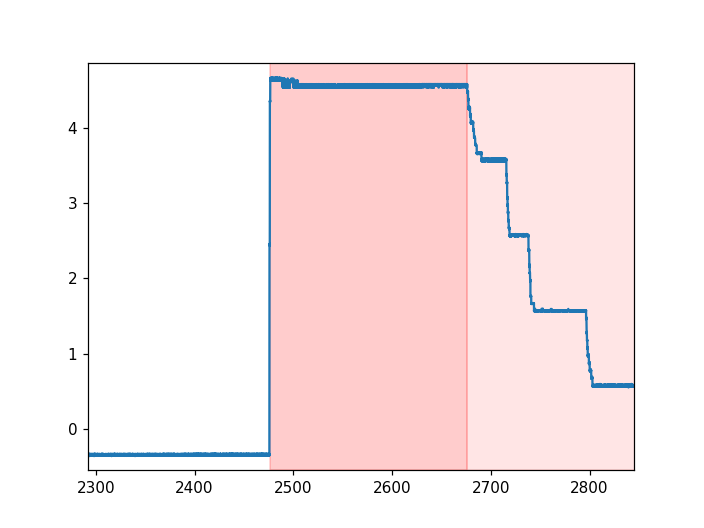

In [16]:
fig, ax = plt.subplots()

ax.plot(iso_time, iso_analog)
ax.axvspan(iso_max_times[0], iso_max_times[1], color='r', alpha=0.2)
ax.axvspan(iso_maint_times[0], iso_maint_times[1], color='r', alpha=0.1)

In [17]:
print(len(eegtimestamps))
print(len(iso_time))

25378816
1015153


In [18]:
print(eegtimestamps[-1] - eegtimestamps[0])
print(iso_time[-1] - iso_time[0])

10151.51055157917
10151.52


<IPython.core.display.Javascript object>


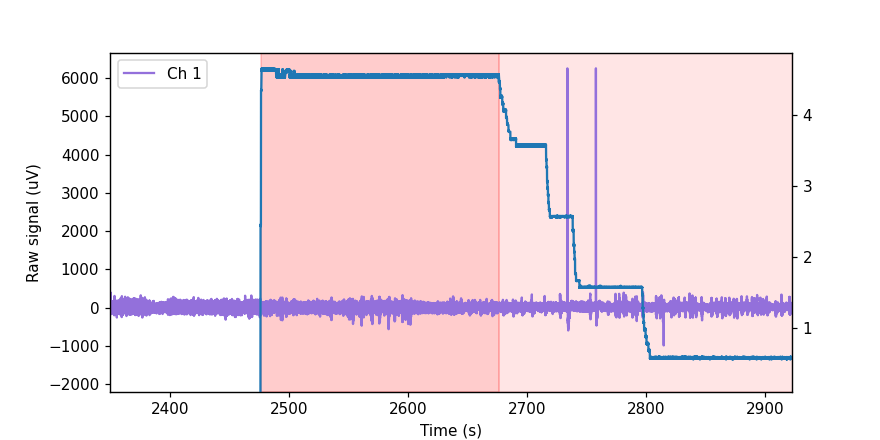

In [19]:
plot_chs = [1]
chcolors = ['mediumpurple','mediumslateblue','rebeccapurple','blueviolet','darkorchid','darkviolet']
# chcolors = ['crimson','blue','gold','green','darkviolet','deeppink']

offset = 500
fig, ax = plt.subplots(figsize=(8, 4))

for i, chi in enumerate(plot_chs):
    ax.plot(eegtimestamps, eegdata[:,chi] + i*offset, color=chcolors[i], label=('Ch {:d}'.format(chi)))

isoax = ax.twinx()
isoax.plot(iso_time, iso_analog)
ax.axvspan(iso_max_times[0], iso_max_times[1], color='r', alpha=0.2)
ax.axvspan(iso_maint_times[0], iso_maint_times[1], color='r', alpha=0.1)
    
# ax.set_xlim((eegtimestamps[0], eegtimestamps[-1]))
# ax.set_ylim((-1.75, 1.75+offset))

ax.set_xlabel('Time (s)')
ax.set_ylabel('Raw signal (uV)')
# ax.set_title('Channel %d' % choose_cha)
ax.legend()

### Load running data

In [25]:
start = time.time()
running, runtime = exp.load_running()
end = time.time()
print((end-start)/60)

264.5513847072919


<IPython.core.display.Javascript object>


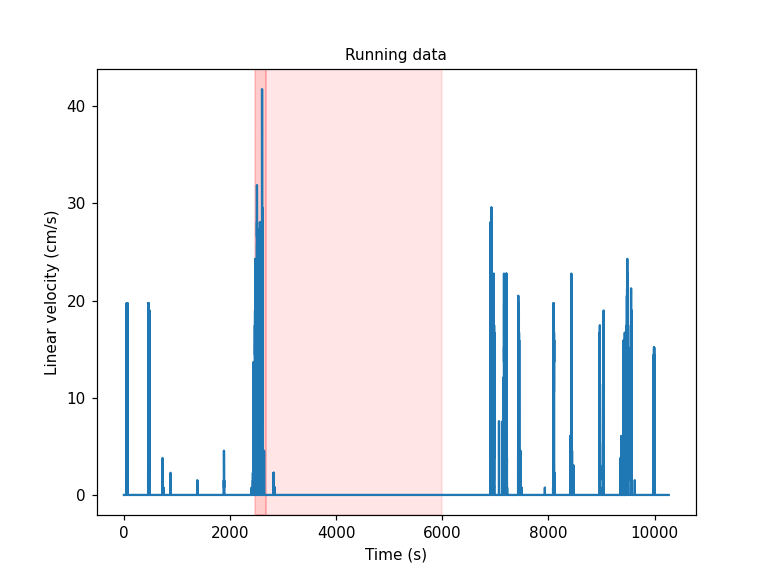

Text(0.5, 1.0, 'Running data')

In [21]:
fig, ax = plt.subplots()

ax.plot(runtime, running)
ax.axvspan(iso_max_times[0], iso_max_times[1], color='r', alpha=0.2)
ax.axvspan(iso_maint_times[0], iso_maint_times[1], color='r', alpha=0.1)
ax.set_ylabel('Linear velocity (cm/s)')
ax.set_xlabel('Time (s)')
ax.set_title('Running data')

# OLD spectral analysis (may have deleted important functions?)

### Make a spectrogram using scipy to plot below raw trace

In [ ]:
f, t, Sxx = signal.spectrogram(cha, exp.sampleRate, nperseg=2**13, scaling='density')
# changing scaling param changes the units of Sxx, check the docs

In [ ]:
frinds = f < 100
print(np.mean(np.mean(Sxx[frinds,:], axis=1)))

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(8,5))

# plot raw signal
axs[0].plot(timex, cha)
axs[0].set_xlim((0, timex[-1]))
axs[0].set_ylim((-0.75, 0.75))
axs[0].axvspan(ind_beg, ind_end, facecolor='r', alpha=0.5)
axs[0].axvspan(ind_end, main_end, facecolor='r', alpha=0.2)
# axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Raw signal (mV)')

# plot spectrogram
spgm = axs[1].pcolormesh(t, f[frinds], Sxx[frinds,:], cmap='Reds', vmin=0, vmax=8)
axs[1].set_ylabel('Frequency (Hz)')
axs[1].set_xlabel('Time (s)')

# do the colorbar :(
fig.subplots_adjust(bottom=0.1, right=0.85, top=0.9, hspace=0.2)
cax = plt.axes([0.9, 0.1, 0.025, 0.36])
cbar = fig.colorbar(spgm, cax=cax)
cbar.ax.set_ylabel('PSD (V**2/Hz)')

### Plot short windows, multi chs

In [ ]:
plchs = np.array([0, 4, 8, 10, 12, 29])

In [ ]:
window_starts = np.array([404., 1342.]) # times of interest in seconds
pl_win_len = 2. # window length in seconds

sep = 250
xtime = np.linspace(0, 2, int(pl_win_len*exp.sampleRate))

In [ ]:
fig, axs = plt.subplots(1, len(window_starts), sharex=True, sharey=True, figsize=(8,4))

for i, winstart in enumerate(window_starts):
    aind = int(winstart*exp.sampleRate)
    bind = aind + int(pl_win_len*exp.sampleRate)
    
    for k, plch in enumerate(plchs):
        
        axs[i].plot(xtime, smooth(eegdata[aind:bind,plch]) + sep*k)
        
    axs[i].set_xlim((0, pl_win_len))
    axs[i].set_ylim((-sep+50, sep*(k+1)+50))
    
axs[0].set_yticks(np.arange(0, sep*len(plchs), sep))
axs[0].set_yticklabels(plchs)
axs[0].set_ylabel('EEG electrode\nposterior -> anterior')
axs[0].set_title('Awake')
axs[0].set_xlabel('Time (s)')

axs[1].tick_params(axis='y', labelleft=False)
plt.setp(axs[1].spines.values(), color='r')
plt.setp([axs[1].get_xticklines(), axs[1].get_yticklines()], color='r')
axs[1].set_title('Anesthetized')
axs[1].set_xlabel('Time (s)')

### Plot short windows, ALL chs

In [ ]:
# zero out bad channels on EEG data
badchs = np.array([28, 29, 30, 31])
eegdata[:,badchs] = 0

In [ ]:
len(intan_to_eeg)

In [ ]:
allplchs = np.arange(0,30)

In [ ]:
window_starts = np.array([404., 1342.]) # times of interest in seconds
pl_win_len = 2. # window length in seconds

sep = 250
xtime = np.linspace(0, 2, int(pl_win_len*testexp.sampleRate))

In [ ]:
fig, axs = plt.subplots(1, len(window_starts), sharex=True, sharey=True, figsize=(8,8))

for i, winstart in enumerate(window_starts):
    aind = int(winstart*testexp.sampleRate)
    bind = aind + int(pl_win_len*testexp.sampleRate)
    
    for k, plch in enumerate(allplchs):
        
        axs[i].plot(xtime, smooth(eegdata[aind:bind,plch]) + sep*k)
        
    axs[i].set_xlim((0, pl_win_len))
    axs[i].set_ylim((-sep+50, sep*(k+1)+50))
    
axs[0].set_yticks(np.arange(0, sep*len(allplchs), sep))
axs[0].set_yticklabels(allplchs)
axs[0].set_ylabel('EEG electrode')
axs[0].set_title('Awake')
axs[0].set_xlabel('Time (s)')

axs[1].tick_params(axis='y', labelleft=False)
plt.setp(axs[1].spines.values(), color='r')
plt.setp([axs[1].get_xticklines(), axs[1].get_yticklines()], color='r')
axs[1].set_title('Anesthetized')
axs[1].set_xlabel('Time (s)')

### Notch filter to remove 60 Hz noise

In [ ]:
# notch-filter out 60 Hz noise
filt_data = notch_filter(cha, testexp.sampleRate, 60, 5, 3, filter_type='butter')

In [ ]:
fig, ax = plt.subplots()
ax.plot(timex, cha)
ax.plot(timex, filt_data, 'r')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Raw signal (uV)')

### Try computing power source density (PSD) using SciPy

#### Static FFT (not Welch's method)

In [ ]:
# "static" FFT over entire period, for comparison with Welch
N = len(cha)
eegpow = np.abs( fftpack.fft(cha)/N )**2
hz = np.linspace(0,exp.sampleRate/2,int(np.floor(N/2)+1))

In [ ]:
fig, ax = plt.subplots()
ax.plot(hz, eegpow[0:len(hz)], 'k', label='Static FFT')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('PSD')

#### Welch's method (computes FFT over windows and averages them, may not be great for a dynamic signal).

In [17]:
welchwinlen = 2 * exp.sampleRate
# nperseg = length of window, power of 2 is most efficient, 2**12 from Doug's notebook
# Signal Processing class uses 2 s window

In [18]:
fa, Pxx_dena = signal.welch(cha, exp.sampleRate, nperseg=welchwinlen)

In [19]:
fb, Pxx_denb = signal.welch(chb, exp.sampleRate, nperseg=welchwinlen)

<IPython.core.display.Javascript object>


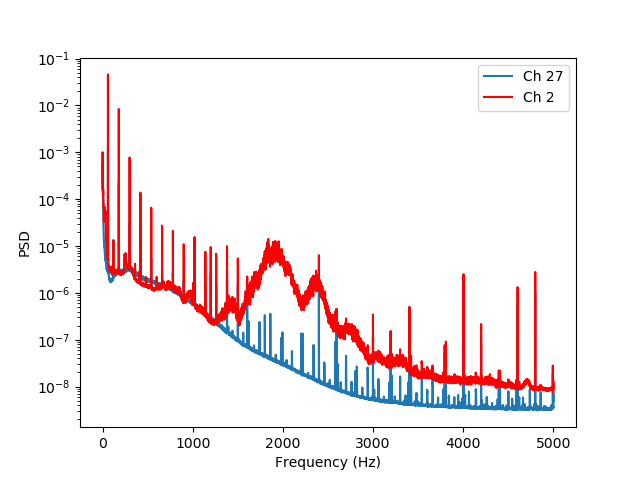

In [21]:
fig, ax = plt.subplots()
ax.semilogy(fa, Pxx_dena, label=('Ch %d' % choose_cha))
ax.semilogy(fb, Pxx_denb, 'r', label=('Ch %d' % choose_chb))
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('PSD')
ax.legend()

<IPython.core.display.Javascript object>


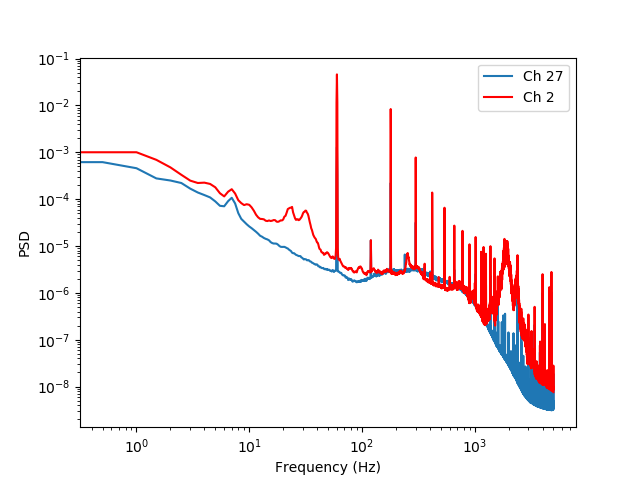

In [20]:
fig, ax = plt.subplots()
ax.loglog(fa, Pxx_dena, label=('Ch %d' % choose_cha))
ax.loglog(fb, Pxx_denb, 'r', label=('Ch %d' % choose_chb))
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('PSD')
ax.legend()